## QA (question answering)

最常用是提取式QA（extractive QA），搜索阶段（关键词检索海量文档）-> 提取答案

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']
DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 255
    })
})
{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answ

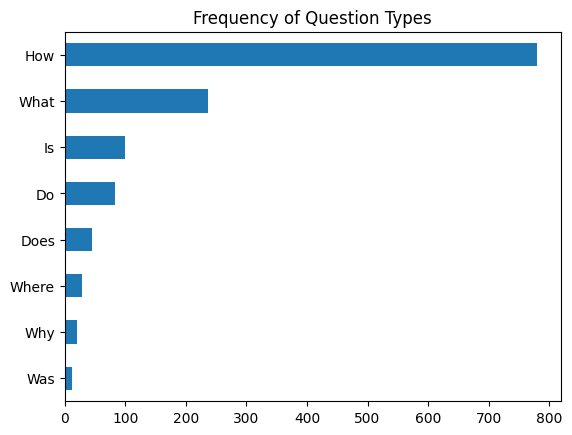

In [5]:
import uuid

from datasets import load_dataset, get_dataset_config_names
from matplotlib import pyplot as plt

domains = get_dataset_config_names('subjqa', trust_remote_code=True)
print(domains)

from datasets import load_dataset

subjqa_dataset = load_dataset('subjqa', name="electronics")
print(subjqa_dataset)
print(subjqa_dataset['train']['answers'][1])

import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa_dataset.flatten().items()}
for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df
## I really like this keyboard.  I give it 4 stars because it doesn't have a CAPS LOCK key so I never know if my caps are on.  But for the price, it really suffices as a wireless keyboard.  I have very large hands and this keyboard is compact, but I have no complaints.
start_idx = sample_df["answers.answer_start"].iloc[0][0]
print(start_idx)
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
print(end_idx)
sample_df["context"].iloc[0][start_idx:end_idx]

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]
for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]
pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

## Tokenization for QA

In [3]:
from transformers import AutoTokenizer
import pandas as pd

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")
print(inputs)

df = pd.DataFrame.from_dict({key: value.tolist()[0] for key, value in inputs.items()}, orient='index')
df
print(tokenizer.decode(inputs["input_ids"][0]))

import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

print('-' * 100)
print(inputs["input_ids"][0])

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

from transformers import pipeline

pipe = pipeline('question-answering', model=model, tokenizer=tokenizer)
result = pipe(question=question, context=context, topk=3)
print(result)

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}
[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)
Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])
----------------------------------------------------------------------------------------------------
tensor([  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
        23378,  2003,  

/Users/admin/Developer/PyProjects/DeepLearing/.venv/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:334: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


## Dealing with long passages

阅读理解模型常遇到的一个问题：上下文包含的token数量比模型可接受的最大长度要多。QA任务，答案很可能就在上下文靠后位置，因此无法直接像分类任务一样，直接截取。

解法：滑动窗口（sliding window），窗口大小一般为模型输入max token；步长（stride）

<br>
<img src="./imgs/qa_sliding_window.png" width="400"/>

在transformer中，可以通过参数 `return_overflowing_tokens = True` 启用tokenizer中的滑动窗口。


In [8]:
example = dfs['train'].iloc[0][['question', 'context']]
tokenize_example = tokenizer(example['question'], example['context'], return_overflowing_tokens=True, max_length=100,
                             stride=25)
print(tokenize_example)

for idx, window in enumerate(tokenize_example['input_ids']):
    print(f"Window #{idx} has {len(window)} tokens")
    print(tokenizer.decode(window))
    print()

{'input_ids': [[101, 2129, 2003, 1996, 3321, 1029, 102, 1045, 2031, 2018, 12849, 4757, 2132, 19093, 1999, 1996, 2627, 1010, 4013, 26424, 2050, 1998, 1053, 2480, 1011, 5585, 1012, 1996, 12849, 4757, 3417, 9331, 3217, 2003, 12109, 1998, 2038, 2307, 3321, 3433, 1012, 1996, 2147, 2307, 2007, 2026, 11924, 3042, 1998, 2064, 2022, 1000, 4565, 2039, 1000, 2000, 2022, 3344, 1999, 2026, 9055, 6598, 2030, 3274, 4524, 2302, 2893, 24514, 2098, 1012, 2027, 2024, 2200, 2422, 1998, 2079, 2025, 2514, 3082, 2030, 4562, 2091, 2006, 2115, 5551, 2130, 2044, 5962, 2000, 2189, 2007, 2068, 2006, 2035, 2154, 1012, 1996, 2614, 2003, 102], [101, 2129, 2003, 1996, 3321, 1029, 102, 1998, 2079, 2025, 2514, 3082, 2030, 4562, 2091, 2006, 2115, 5551, 2130, 2044, 5962, 2000, 2189, 2007, 2068, 2006, 2035, 2154, 1012, 1996, 2614, 2003, 2305, 1998, 2154, 2488, 2084, 2151, 4540, 1011, 13007, 2071, 2022, 1998, 2024, 2471, 2004, 2204, 2004, 1996, 4013, 26424, 2050, 1012, 2027, 2024, 1000, 2330, 2250, 1000, 2132, 19093, 2061,

## 现代QA模型的Retriever-reader 架构

### 核心组件
* Retriever 执行检索任务，搜索问题相关内容作为上下文给模型
* Reader  阅读理解模型，基于Retriever提供的上下文以及用户的问题，提取答案。

<img src="./imgs/retriever_reader_arch_qa_system.png" width="400"/>

### 文本检索方法
- TF-IDF （Term Frequency – Inverse Document Frequency）用词频衡量关键词的重要性，
    - TF：一个词在当前文档中出现了几次
    - IDF：这个词在整个语料库中有多“少见”
    - 常见词（比如“的”、“是”）权重低，少见但频繁出现在某篇文章的词，权重高。

- BM25（Best Match 25）TF-IDF 的升级版，更适合搜索引擎用
    - 除了词频，还考虑文档长度、词的位置、查询词的“饱和效应”（词出现太多次也不会无限加分）
    - 关键词越集中、文档越短、匹配得越好，得分越高。
    > 搜“Python 教程”，短小精悍、密集出现“Python”的文章会得分高。
- Embedding 向量表示。把句子/单词变成一个“数字向量”，能表达语义。
    - 不再看词频，而是用机器学习模型训练出来的词向量/句向量
    - 相似度用余弦距离等方式比较
    > “我喜欢猫”和“I love cats”意思很像，用 embedding 表示后两个向量很接近。
    - 适合做语义匹配，找“意思相近”的句子或文档，而不仅仅是关键词匹配。
- DPR (Dense Passage Retrieval） 用两个 BERT 模型，一个编码问题，一个编码文档，做“语义搜索”。
    - embedding 的进阶版
    - Dual Encoder 架构：问题和文档各自变成一个向量，然后比相似度
    - 用大规模问答数据训练（如自然问答对）,不仅能找关键词相似的文章，还能找语义能回答问题的段落。

<img src="./imgs/semantic_relevance_algo_doc_storages.png" width="400"/>

### Haystack library (from DeepSet)
* Document store 文档数据库，元数据，Retriever检索时使用
* Pipeline 组合QA系统组件，合并retriever检索到的文档，使用阅读理解模型提取答案

In [22]:
!curl -X GET "localhost:9200/?pretty"


from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack import Document

doc_store = ElasticsearchDocumentStore(hosts="http://localhost:9200", timeout=60)

from datasets import load_dataset
import uuid

subjqa_dataset = load_dataset('subjqa', name="electronics")

import pandas as pd

# dfs = {split: dset.to_pandas() for split, dset in subjqa_dataset.flatten().items()}
# for split, df in dfs.items():
#     docs = [Document(content=row["context"], meta={"item_id": row["title"], "question_id": row["id"], "split": split})
#             for _, row in df.drop_duplicates(subset="context").iterrows()]
#     doc_store.write_documents(docs)
print(f"Loaded {doc_store.count_documents()} documents")

from haystack_integrations.components.retrievers.elasticsearch import bm25_retriever

es_retriever = bm25_retriever.ElasticsearchBM25Retriever(document_store=doc_store)
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.run(
    query=query, top_k=3, filters={
        "operator": "AND",
        "conditions": [
            {"field": "item_id", "operator": "==", "value": "B0074BW614"},
            {"field": "split", "operator": "==", "value": "train"}
        ]
    })
print(retrieved_docs['documents'][0].content)

from haystack.components.readers import ExtractiveReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
reader = ExtractiveReader(model=model_ckpt, max_seq_length=max_seq_length, stride=doc_stride, no_answer=True)
reader.warm_up()
print(reader.run(query=query, top_k=1, documents=[Document(content=context, id=str(uuid.uuid4()))]))

#use pipeline 
from haystack.core.pipeline import Pipeline

#组装pipeline
pipe = Pipeline()
pipe.add_component('retriever', es_retriever)
pipe.add_component('reader', reader)

# 建立链接
pipe.connect('retriever', 'reader')
n_answers = 3
preds = pipe.run(data={"retriever": {"query": query}, "reader": {"query": query
    , "top_k": 3}})
print(f"Question: {preds['reader']['answers'][0]} \n")
answers = preds['reader']['answers']
for idx in range(n_answers):
    print(f"Answer {idx + 1}: {answers[idx].data}")
    print(f"Review snippet: ...{answers[idx].document.content}...")
    print("\n\n")
 

{
  "name" : "fenghd.local",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "EoQ82iqsSXaqVsgDLSGlAA",
  "version" : {
    "number" : "8.11.4",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "da06c53fd49b7e676ccf8a32d6655c5155c16d81",
    "build_date" : "2024-01-08T10:05:08.438562403Z",
    "build_snapshot" : false,
    "lucene_version" : "9.8.0",
    "minimum_wire_compatibility_version" : "7.17.0",
    "minimum_index_compatibility_version" : "7.0.0"
  },
  "tagline" : "You Know, for Search"
}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loaded 1875 documents
I had originally bought a Kindle Fire for my mom to read books when she went on vacation. I played around with it for a week or two (loading it with eBooks and making sure I was familiar with it before handing it over) During the time I really enjoyed the device, but wasn't sure I had enough of a need to buy my own.In comes the Kindle Fire HD 7" I happened to be at Best Buy checking them out when I realized that I do buy books quite frequently, and that I could use one. I took a few days to decide what device was best for me, and thanks to the people I work with I had a chance to compare the Kindle Fire HD and a Nexus 7 side by side.Comparison, Performance wise they are a very close match, I would say the Nexus is slightly faster over all. but not enough that it would matter in the end. my deciding factor was the Amazon experience. I wanted that User Interface, where I see what I am looking for as soon as I turn on the device. I did not want the  distractions of o

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'answers': [ExtractedAnswer(query='Is it good for reading?', score=0.5065422654151917, data='about 6000 hours depending on file size', document=Document(id=a79b68f2-429a-4ba9-a1d2-5e20e940a0ec, content: 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.'), context=None, document_offset=ExtractedAnswer.Span(start=32, end=71), context_offset=None, meta={}), ExtractedAnswer(query='Is it good for reading?', score=0.49345773458480835, data=None, document=None, context=None, document_offset=None, context_offset=None, meta={})]}
Question: ExtractedAnswer(query='Is it good for reading?', score=0.775586724281311, data='This is a good tablet for reading books', document=Document(id=9a9a7e6f969ed160551da92db5ef48146504e6e7d11f0d714ef05c968d1b5bb9, content: 'I really haven't found anything to dislike about this. It's a considerable improvement over the prev...', meta: {'item_id': 'B00DVFLJDS', 'question_id': 'f9a7e7eb40501bf4a2bda84799f6fdd0', 'split': 'train'}, score: 9.18

## Improving QA pipeline

Retriever获取到的文档相关性高低决定了整个QA系统的上限，毕竟阅读理解模型的输入依赖于Retriever的输出。

### Evaluate Retriever

核心评判指标：`recall` 

Haystack中，有两种评判Retriever指标的方式：
* Retriever内置的eval() 方法
* custom metrics in Pipeline




In [105]:
from typing import Any, List
from haystack.components.converters import OutputAdapter
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchBM25Retriever
from haystack.components.evaluators import DocumentRecallEvaluator, DocumentMRREvaluator
from haystack.core.pipeline import Pipeline
from haystack import Document, component
import pandas as pd

# Step 1: 初始化 DocumentStore
doc_store = ElasticsearchDocumentStore(hosts="http://localhost:9200", index="default")
# doc_store.write_documents(documents)

# Step 3: 初始化 Retriever
retriever = ElasticsearchBM25Retriever(document_store=doc_store, top_k=1)
first = retriever.run(query = "Is it good for reading?")['documents'][0].content

# Step 4: 设定评估用的问题与 ground_truth
eval_queries = [
    {
        "query": "Is it good for reading?",
        "ground_truths": [first]
    }
]

@component
class WrapListOutputAdapter:
    """
    将 List[Document] 包装为 List[List[Document]]。
    """
    
    def __init__(self):
        print("WrapListOutputAdapter init")

    @component.output_types(output=List[List[Document]])
    def run(self, value: Any):
        print("WrapListOutputAdapter call:{}".format(value))
        if isinstance(value, list) and all(isinstance(doc, Document) for doc in value):
            return {"output": [value]}  # 包成一层
        else:
            raise ValueError("Input must be a List[Document]")
        
# Step 5: 设置评估组件
evaluator = DocumentRecallEvaluator()
# Step 6: 构建管道并连接组件
pipe = Pipeline()
pipe.add_component("output_adapter", WrapListOutputAdapter())
pipe.add_component("retriever", retriever)
pipe.connect("retriever.documents", "output_adapter")
pipe.add_component("eval", evaluator) 
pipe.connect('output_adapter.output', 'eval.retrieved_documents')

# Step 7: 运行评估
results = []
for q in eval_queries:
    output = pipe.run(data={"retriever": {"query": q["query"]}, "eval": {"ground_truth_documents": [[Document(content=q["ground_truths"][0])]]}})
    print(output)
    results.append(output)

# Step 8: 输出评估结果
df = pd.DataFrame(results)
print(df)

# Optional: 打印平均分
print("\nAverage metrics:")
print(df.mean(numeric_only=True))

WrapListOutputAdapter init
WrapListOutputAdapter call:[Document(id=9a9a7e6f969ed160551da92db5ef48146504e6e7d11f0d714ef05c968d1b5bb9, content: 'I really haven't found anything to dislike about this. It's a considerable improvement over the prev...', meta: {'item_id': 'B00DVFLJDS', 'question_id': 'f9a7e7eb40501bf4a2bda84799f6fdd0', 'split': 'train'}, score: 9.189323)]
{'eval': {'score': 1.0, 'individual_scores': [1.0]}}
                                         eval
0  {'score': 1.0, 'individual_scores': [1.0]}

Average metrics:
Series([], dtype: float64)


## RAG 

RAG模型分为两种：  
* RAG-Sequence (使用召回的top k文档生成最终的答案)
* RAG-Token（使用不同的文档生成答案的token）—-更优  



